In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-04-13 15:29:53.961277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744558194.189575      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744558194.255999      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/stock-code/VIC.csv")

# Calculate log returns and volatility
# df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

df['Log_Return'] = df['Close'] - df['Close'].shift(1)
df['Volatility'] = df['Log_Return'].rolling(window=5).std()

# Drop NaNs after volatility calculation
df = df.dropna().reset_index(drop=True)

In [3]:
# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Volatility'

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])

# Prepare sequences for LSTM
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(target[i])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_features, df[target].values, seq_length)

In [4]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

2025-04-13 15:30:08.287408: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 116s 22ms/step - loss: 0.0265 - val_loss: 0.0235
Epoch 2/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - loss: 0.0255 - val_loss: 0.0231
Epoch 3/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - loss: 0.0224 - val_loss: 0.0227
Epoch 4/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 142s 22ms/step - loss: 0.0222 - val_loss: 0.0220
Epoch 5/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 111s 22ms/step - loss: 0.0230 - val_loss: 0.0214
Epoch 6/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0230 - val_loss: 0.0214
Epoch 7/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0229 - val_loss: 0.0213
Epoch 8/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0210 - val_loss: 0.0203
Epoch 9/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0210 - val_loss: 0.0179
Epoch 10/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0189 - val_loss: 0.0143
Epoch 11/20
5062/5062 ━━━━━━━━━━━━━━━━━━━━ 112s 22ms/step - loss: 0.0180 - val_loss: 0.01

In [7]:
# Predict
y_pred = model.predict(X_test)

633/633 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


In [8]:
# Evaluation
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_pred, y_test)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

MSE: 0.007492
RMSE: 0.086556
MAE: 0.047950


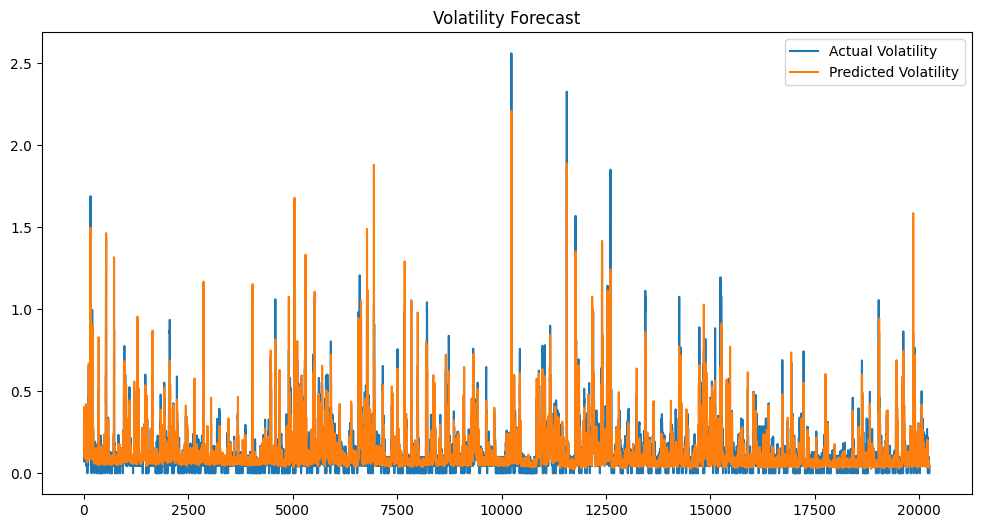

In [9]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Volatility')
plt.plot(y_pred, label='Predicted Volatility')
plt.title("Volatility Forecast")
plt.legend()
plt.show()